In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df.columns

Index(['slp', 'rlm', 'gas_to_electricity', 'electricity_from_gas',
       'gas_price [€/MWh]', 'producing_sector', 'manufacturing_sector',
       'retail_sector', 'residential', 'commercial', 'decentral_chp',
       'industry_buildings', 'aggregated', 'index', 'time', 'year', 'month',
       'weekday', 'weekday_num', 'monday', 'friday', 'weekend',
       'christmas_period', 'holiday', 'bridgeday'],
      dtype='object')

# Prepare regression data

In [285]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'electricity_from_gas': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'gas_price [€/MWh]': 'prices'
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
# dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-01-01')]

In [259]:
crisis_start = "2021-09-01"
fitting_start = "2017-09-01"
# invasion_date = "2022-02-24"

Monthly treatment dummies from Sep 2021 onwards:

In [301]:
def model(consumer='rlm', further_controls=False):
    
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)
    
    results = {}
    
    for name in ['naive', 'temp'] + (
        ['temp+power', 'temp+power+econ'] if consumer=='rlm' else []
    ):
    
        m = f'{"log_" if log else ""}{consumer} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
        
        if further_controls:
            control_list = []
            for date in pd.date_range(fitting_start, pd.Timestamp(crisis_start) - pd.Timedelta('1y'), freq='1m'):
                dummy_name = f'm{date.year}_{date.month}'
                dfx.loc[dfx.index, dummy_name] = dfx.index.map(
                    lambda x: (x.year==date.year) & (x.month==date.month)
                ).values
                control_list.append(dummy_name)
            m += ' + ' + ' + '.join(control_list)
        
        if 'temp' in name:
            m += ' + residential + commercial'
        if 'power' in name:
            m += ' + power'
        if 'econ' in name:
            m += ' + manu'
    
        results[name] = smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

    return results

In [252]:
def extract_results(results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

In [253]:
def plot(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    i += 1
    ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
    ax.plot([i,i], [res['low'], res['high']], color=colors[i])
    
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title('Small consumers' if consumer=='slp' else 'Large consumers')
    #if log:
    #    ax.set_ylim(-21, 7)
    ax.set_xticks(range(len(results)+1), ['Overall', 'Temperature', 'Power\nsector', 'Economic\nactivity'][:len(results)] + ['Extraordinary\nresponse'])

# One crisis dummy
Log-linear model

In [288]:
def one_dummy(further_controls=False):
    
    dummy_list=['crisis']

    results = {consumer: model(consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4.5), sharey='row', gridspec_kw={'width_ratios': [1.2,2]})

    res = {m: extract_results(value) for m, value in results['slp'].items()}
    ax1 = plot(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(value) for m, value in results['rlm'].items()}
    ax2 = plot(ax2, res, 'rlm')

    plt.tight_layout()
    plt.savefig(f'one_dummy{"_log" if log else ""}.png', dpi=300)
    
    return results

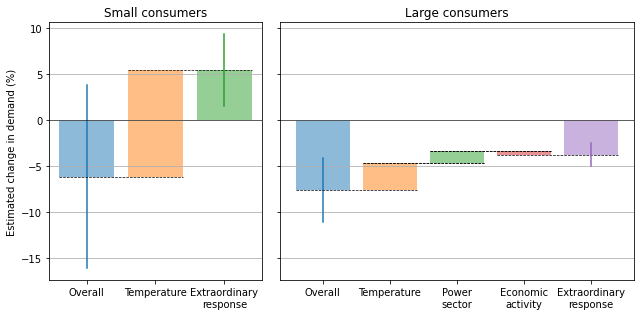

In [274]:
log=True
fitting_start = "2017-01-01"
crisis_start = "2021-09-01"
results_log = one_dummy()

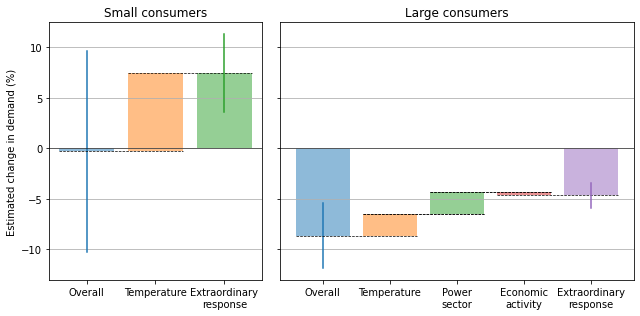

In [275]:
log=True
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results_log = one_dummy()

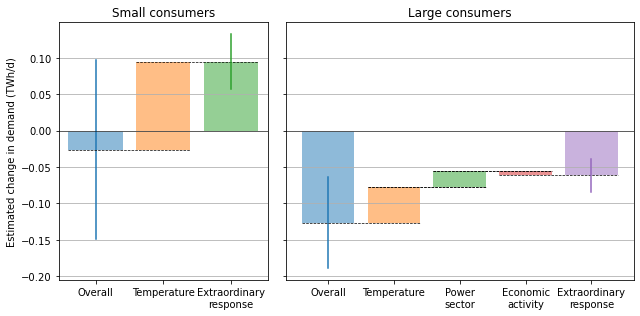

In [304]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01"
results = one_dummy()

# secondary axis (% of ind. demand)
# 366 TWh/y -> https://gas.info/fileadmin/Public/PDF-Download/Faktenblatt-Erdgas.pdf

# control for slp economic activity ()

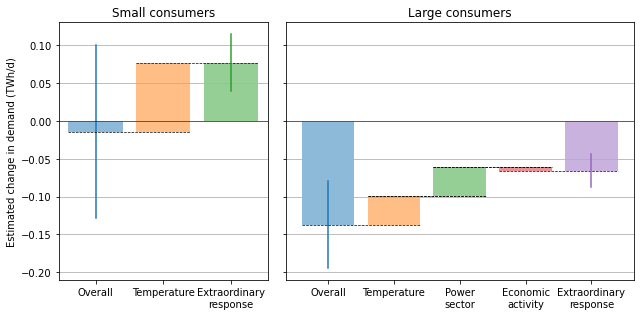

In [310]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy()

In [312]:
results['rlm']['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     577.4
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:37:13   Log-Likelihood:                 1724.2
No. Observations:                1764   AIC:                            -3404.
Df Residuals:                    1742   BIC:                            -3284.
Df Model:                          21                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.3270      0.044     29.900      0.000       1.240       1.414
C(month)[T.2]              -0.0389      0.023     -1.658      0.097      -0.085       0.007
C(month)[T.3]              -0.1189      0.027     -4.414      0.000      -0.172      -0.066
C(month)[T.4]              -0.1824      0.031     -5.876      0.000      -0.243      -0.122
C(month)[T.5]              -0.1872      0.029     -6.450      0.000      -0.244      -0.130
C(month)[T.6]              -0.1381      0.032     -4.258      0.000      -0.202      -0.075
C(month)[T.7]              -0.1383      0.034     -4.084      0.000      -0.205      -0.072
C(month)[T.8]              -0.1619      0.033     -4.875      0.000      -0.227      -0.097
C(month)[T.9]              -0.1099      0.031     -3.519      0.000      -0.171      -0.049
C(month)[T.10]             -0.0639      0.027     -2.335      0.020      -0.117      -0.010
C(month)[T.11]             -0.0098      0.022     -0.437      0.662      -0.054       0.034
C(month)[T.12]             -0.0297      0.025     -1.193      0.233      -0.078       0.019
C(weekday)[T.Monday]        0.0514      0.006      7.933      0.000       0.039       0.064
C(weekday)[T.Saturday]     -0.2271      0.007    -33.994      0.000      -0.240      -0.214
C(weekday)[T.Sunday]       -0.2309      0.007    -32.400      0.000      -0.245      -0.217
C(weekday)[T.Thursday]      0.0619      0.005     11.348      0.000       0.051       0.073
C(weekday)[T.Tuesday]       0.0663      0.007      9.588      0.000       0.053       0.080
C(weekday)[T.Wednesday]     0.0660      0.007     10.080      0.000       0.053       0.079
crisis[T.True]             -0.0992      0.017     -5.736      0.000      -0.133      -0.065
time                     5.442e-05   1.05e-05      5.203      0.000    3.39e-05    7.49e-05
residential                 0.1429      0.134      1.063      0.288      -0.121       0.406
commercial                  1.0344      0.263      3.937      0.000       0.519       1.549
==============================================================================
Omnibus:                      115.657   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.658
Skew:                          -0.356   Prob(JB):                     1.90e-66
Kurtosis:                       4.900   Cond. No.                     9.28e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
[2] The condition number is large, 9.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\olive\AppData\Local\Temp\ipykernel_7364\2379692756.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  results = {consumer: model(consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
C:\Users\olive\AppData\Local\Temp\ipykernel_7364\2379692756.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  results = {consumer: model(consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
C:\Users\olive\AppData\Local\Temp\ipykernel_7364\2379692756.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  results = {consumer: model(consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
C:\Users\olive\AppData\Local\Temp\ipykernel_7364\2379692756.py:5: FutureWarning: Units 'M', 'Y' and 'y' do no

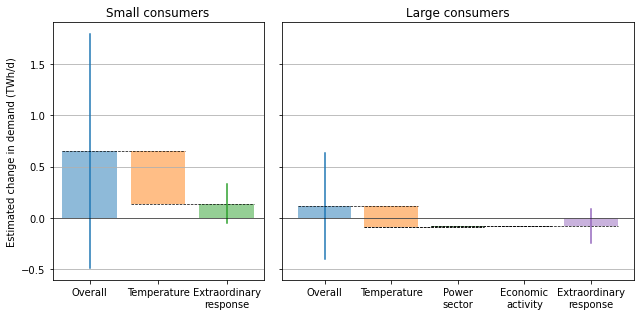

In [313]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results_fc = one_dummy(further_controls=True)

In [230]:
results['rlm']['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     473.8
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:43:08   Log-Likelihood:                 1442.0
No. Observations:                1534   AIC:                            -2840.
Df Residuals:                    1512   BIC:                            -2723.
Df Model:                          21                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.2865      0.050     25.953      0.000       1.189       1.384
C(month)[T.2]              -0.0330      0.025     -1.345      0.179      -0.081       0.015
C(month)[T.3]              -0.1159      0.028     -4.150      0.000      -0.171      -0.061
C(month)[T.4]              -0.1730      0.035     -4.959      0.000      -0.241      -0.105
C(month)[T.5]              -0.1920      0.028     -6.740      0.000      -0.248      -0.136
C(month)[T.6]              -0.1197      0.034     -3.558      0.000      -0.186      -0.054
C(month)[T.7]              -0.1287      0.036     -3.616      0.000      -0.198      -0.059
C(month)[T.8]              -0.1627      0.039     -4.140      0.000      -0.240      -0.086
C(month)[T.9]              -0.0967      0.032     -3.013      0.003      -0.160      -0.034
C(month)[T.10]             -0.0528      0.028     -1.886      0.059      -0.108       0.002
C(month)[T.11]              0.0028      0.022      0.128      0.898      -0.041       0.046
C(month)[T.12]             -0.0161      0.025     -0.656      0.512      -0.064       0.032
C(weekday)[T.Monday]        0.0516      0.007      7.336      0.000       0.038       0.065
C(weekday)[T.Saturday]     -0.2325      0.008    -30.665      0.000      -0.247      -0.218
C(weekday)[T.Sunday]       -0.2352      0.008    -29.175      0.000      -0.251      -0.219
C(weekday)[T.Thursday]      0.0635      0.006     10.547      0.000       0.052       0.075
C(weekday)[T.Tuesday]       0.0661      0.008      8.705      0.000       0.051       0.081
C(weekday)[T.Wednesday]     0.0677      0.007      9.325      0.000       0.053       0.082
crisis[T.True]             -0.0927      0.020     -4.686      0.000      -0.132      -0.054
time                      6.55e-05   1.31e-05      5.015      0.000    3.99e-05    9.11e-05
residential                 0.2356      0.153      1.540      0.123      -0.064       0.535
commercial                  0.8497      0.295      2.884      0.004       0.272       1.427
==============================================================================
Omnibus:                       88.472   Durbin-Watson:                   0.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.850
Skew:                          -0.364   Prob(JB):                     2.19e-42
Kurtosis:                       4.572   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [219]:
df['rlm'].mean()

1.6109986768146596

# Quarterly dummies

In [85]:
mode = 'quarterly'
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

In [92]:
mode = 'monthly'
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

## SLP

In [86]:
results_slp_log = {}
for m in ['naive', 'temp']:
    model = 'log_slp ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
    if 'temp' in m:
        model += ' + residential + commercial'
    results_slp_log[m] = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp_log['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_slp   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     807.2
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:23:46   Log-Likelihood:                 926.08
No. Observations:                1085   AIC:                            -1800.
Df Residuals:                    1059   BIC:                            -1670.
Df Model:                          25                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.4295      0.131    -10.924      0.000      -1.686      -1.173
C(month)[T.2]               0.0420      0.031      1.344      0.179      -0.019       0.103
C(month)[T.3]               0.0341      0.021      1.615      0.106      -0.007       0.076
C(month)[T.4]              -0.0959      0.042     -2.282      0.022      -0.178      -0.014
C(month)[T.5]              -0.2055      0.053     -3.897      0.000      -0.309      -0.102
C(month)[T.6]              -0.5980      0.085     -7.067      0.000      -0.764      -0.432
C(month)[T.7]              -0.6187      0.082     -7.546      0.000      -0.779      -0.458
C(month)[T.8]              -0.6356      0.081     -7.801      0.000      -0.795      -0.476
C(month)[T.9]              -0.4093      0.066     -6.232      0.000      -0.538      -0.281
C(month)[T.10]             -0.0988      0.044     -2.255      0.024      -0.185      -0.013
C(month)[T.11]              0.0096      0.028      0.347      0.728      -0.044       0.064
C(month)[T.12]              0.0160      0.026      0.622      0.534      -0.035       0.067
C(weekday)[T.Monday]        0.0358      0.008      4.524      0.000       0.020       0.051
C(weekday)[T.Saturday]     -0.1289      0.012    -10.947      0.000      -0.152      -0.106
C(weekday)[T.Sunday]       -0.1142      0.012     -9.928      0.000      -0.137      -0.092
C(weekday)[T.Thursday]      0.0428      0.006      6.876      0.000       0.031       0.055
C(weekday)[T.Tuesday]       0.0376      0.008      4.544      0.000       0.021       0.054
C(weekday)[T.Wednesday]     0.0235      0.007      3.270      0.001       0.009       0.038
d2021_1[T.True]             0.0730      0.037      1.984      0.047       0.001       0.145
d2021_2[T.True]             0.1576      0.039      4.087      0.000       0.082       0.233
d2021_3[T.True]             0.1119      0.036      3.109      0.002       0.041       0.182
d2021_4[T.True]             0.1159      0.029      4.060      0.000       0.060       0.172
d2022_1[T.True]             0.1161      0.040      2.868      0.004       0.037       0.195
time                     1.513e-05   4.02e-05      0.376      0.707   -6.38e-05     9.4e-05
residential                 4.0444      0.344     11.764      0.000       3.371       4.718
commercial                 -5.2865      0.583     -9.071      0.000      -6.429      -4.144
==============================================================================
Omnibus:                      176.235   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.287
Skew:                          -0.883   Prob(JB):                     4.47e-93
Kurtosis:                       5.508   Cond. No.                     1.26e+05
====================

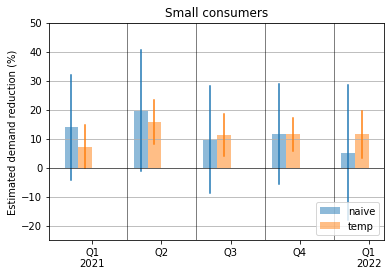

In [88]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

if mode=='monthly':
    plt.figure(figsize=(8,4))

for i, m in enumerate(['naive', 'temp']):
    
    extracted_results = extract_results(results_slp_log[m], dummy_list=dummy_list)
    
    idx = [j-0.3+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('Small consumers')
plt.ylim(-25, 50)
if mode=='monthly':
    plt.xticks(range(len(extracted_results)), 
               [f'{date.month_name()[:3]}'+(f'\n{date.year}' if date.month==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='1m')])    
else:
    plt.xticks(range(len(extracted_results)), 
               [f'Q{date.quarter}'+(f'\n{date.year}' if date.quarter==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='3m')])    
plt.legend(loc='lower right')
plt.savefig('slp_quarterly.png', dpi=300)

In [61]:
dfx['log_slp'] = np.log(dfx['slp'])

model = 'log_slp ~ 1 + w2h + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
results_slp_log = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_slp   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     382.6
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:13:52   Log-Likelihood:                 683.68
No. Observations:                1085   AIC:                            -1317.
Df Residuals:                    1060   BIC:                            -1193.
Df Model:                          24                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.8421      0.097     -8.648      0.000      -1.033      -0.651
C(month)[T.2]               0.0623      0.029      2.171      0.030       0.006       0.119
C(month)[T.3]               0.0563      0.025      2.265      0.024       0.008       0.105
C(month)[T.4]              -0.0220      0.045     -0.489      0.625      -0.110       0.066
C(month)[T.5]              -0.1453      0.057     -2.530      0.011      -0.258      -0.033
C(month)[T.6]              -0.7555      0.086     -8.788      0.000      -0.924      -0.587
C(month)[T.7]              -0.7771      0.080     -9.707      0.000      -0.934      -0.620
C(month)[T.8]              -0.8030      0.077    -10.495      0.000      -0.953      -0.653
C(month)[T.9]              -0.4353      0.071     -6.122      0.000      -0.575      -0.296
C(month)[T.10]             -0.0348      0.046     -0.764      0.445      -0.124       0.054
C(month)[T.11]              0.0540      0.034      1.605      0.108      -0.012       0.120
C(month)[T.12]              0.0420      0.035      1.205      0.228      -0.026       0.110
C(weekday)[T.Monday]       -0.0024      0.010     -0.234      0.815      -0.022       0.017
C(weekday)[T.Saturday]      0.0029      0.007      0.395      0.692      -0.011       0.017
C(weekday)[T.Sunday]        0.0033      0.009      0.347      0.729      -0.015       0.022
C(weekday)[T.Thursday]      0.0058      0.008      0.718      0.473      -0.010       0.022
C(weekday)[T.Tuesday]       0.0052      0.011      0.476      0.634      -0.016       0.027
C(weekday)[T.Wednesday]     0.0085      0.010      0.836      0.403      -0.011       0.028
d2021_1[T.True]             0.1281      0.042      3.080      0.002       0.047       0.210
d2021_2[T.True]             0.1191      0.053      2.228      0.026       0.014       0.224
d2021_3[T.True]             0.0927      0.057      1.617      0.106      -0.020       0.205
d2021_4[T.True]             0.1148      0.039      2.941      0.003       0.038       0.191
d2022_1[T.True]             0.1544      0.057      2.706      0.007       0.043       0.266
w2h                         0.7469      0.034     21.679      0.000       0.679       0.814
time                     1.896e-05   6.07e-05      0.312      0.755      -0.000       0.000
==============================================================================
Omnibus:                       47.466   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.877
Skew:                          -0.271   Prob(JB):                     3.38e-22
Kurtosis:                       4.376   Cond. No.                     2.68e+04
==============================================================================

Notes:
[1] Standard Errors are h

(-5.0, 25.0)

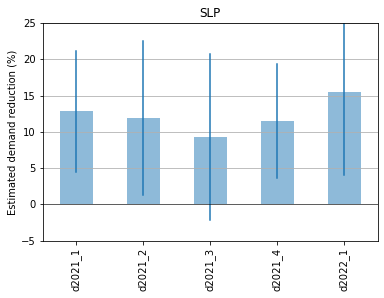

In [62]:
extracted_results = extract_results(results_slp_log, dummy_list=dummy_list)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('SLP')
plt.ylim(-5, 25)

## RLM

In [93]:
dfx['log_rlm'] = np.log(dfx['rlm'])

results_rlm_log = {}
for m in ['naive', 'temp', 'temp+power', 'temp+power+econ']:
    model = 'log_rlm ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
    if 'temp' in m:
        model += ' + residential + commercial'
    if 'power' in m:
        model += ' + power'
    if 'econ' in m:
        model += ' + manu'
    results_rlm_log[m] = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm_log['temp+power+econ'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_rlm   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1242.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:25:11   Log-Likelihood:                 2188.8
No. Observations:                1085   AIC:                            -4302.
Df Residuals:                    1047   BIC:                            -4112.
Df Model:                          37                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.1413      0.053     -2.689      0.007      -0.244      -0.038
C(month)[T.2]              -0.0221      0.010     -2.318      0.020      -0.041      -0.003
C(month)[T.3]              -0.0767      0.013     -5.758      0.000      -0.103      -0.051
C(month)[T.4]              -0.1168      0.011    -10.457      0.000      -0.139      -0.095
C(month)[T.5]              -0.1274      0.010    -12.732      0.000      -0.147      -0.108
C(month)[T.6]              -0.0813      0.014     -5.797      0.000      -0.109      -0.054
C(month)[T.7]              -0.0914      0.012     -7.521      0.000      -0.115      -0.068
C(month)[T.8]              -0.0781      0.015     -5.069      0.000      -0.108      -0.048
C(month)[T.9]              -0.0926      0.012     -7.476      0.000      -0.117      -0.068
C(month)[T.10]             -0.0629      0.012     -5.262      0.000      -0.086      -0.039
C(month)[T.11]             -0.0434      0.011     -3.999      0.000      -0.065      -0.022
C(month)[T.12]             -0.0206      0.012     -1.776      0.076      -0.043       0.002
C(weekday)[T.Monday]        0.0502      0.003     15.120      0.000       0.044       0.057
C(weekday)[T.Saturday]     -0.1418      0.004    -36.314      0.000      -0.149      -0.134
C(weekday)[T.Sunday]       -0.1211      0.005    -26.074      0.000      -0.130      -0.112
C(weekday)[T.Thursday]      0.0434      0.003     15.226      0.000       0.038       0.049
C(weekday)[T.Tuesday]       0.0482      0.003     14.887      0.000       0.042       0.055
C(weekday)[T.Wednesday]     0.0423      0.003     13.072      0.000       0.036       0.049
d2021_1[T.True]             0.0347      0.011      3.034      0.002       0.012       0.057
d2021_2[T.True]             0.0300      0.013      2.311      0.021       0.005       0.055
d2021_3[T.True]             0.0372      0.016      2.296      0.022       0.005       0.069
d2021_4[T.True]             0.0522      0.016      3.207      0.001       0.020       0.084
d2021_5[T.True]             0.0379      0.013      2.957      0.003       0.013       0.063
d2021_6[T.True]            -0.0162      0.014     -1.127      0.260      -0.044       0.012
d2021_7[T.True]            -0.0354      0.018     -1.955      0.051      -0.071    8.95e-05
d2021_8[T.True]            -0.0986      0.014     -7.028      0.000      -0.126      -0.071
d2021_9[T.True]            -0.0646      0.011     -5.704      0.000      -0.087      -0.042
d2021_10[T.True]           -0.0573      0.014     -4.109      0.000      -0.085      -0.030
d2021_11[T.True]           -0.0172      0.011     -1.637      0.102      -0.038       0.003
d2021_12[T.True]           -0.0297      0.021     -1.443      0.149      -0.070       0.011
d2022_1[T.True]            -0.0358      0.015  

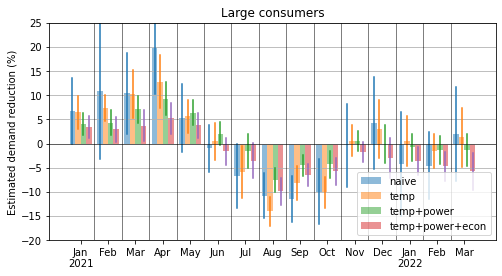

In [97]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

if mode=='monthly':
    plt.figure(figsize=(8,4))

for i, m in enumerate(['naive', 'temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm_log[m], dummy_list=dummy_list)
    
    idx = [j-0.3+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('Large consumers')
plt.ylim(-20, 25)
if mode=='monthly':
    plt.xticks(range(len(extracted_results)), 
               [f'{date.month_name()[:3]}'+(f'\n{date.year}' if date.month==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='1m')])    
else:
    plt.xticks(range(len(extracted_results)), 
               [f'Q{date.quarter}'+(f'\n{date.year}' if date.quarter==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='3m')])    
plt.legend(loc='lower right')
plt.savefig('rlm_log.png', dpi=300)

# Linear models
SLP

In [377]:
model = 'slp ~ 1 + w2h + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
results_slp = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    slp   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3727.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:04:37   Log-Likelihood:                 1580.2
No. Observations:                1085   AIC:                            -3110.
Df Residuals:                    1060   BIC:                            -2986.
Df Model:                          24                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1893      0.041      4.573      0.000       0.108       0.270
C(month)[T.2]              -0.0012      0.018     -0.065      0.948      -0.037       0.035
C(month)[T.3]              -0.0826      0.016     -5.273      0.000      -0.113      -0.052
C(month)[T.4]              -0.0881      0.027     -3.314      0.001      -0.140      -0.036
C(month)[T.5]              -0.1442      0.027     -5.261      0.000      -0.198      -0.090
C(month)[T.6]              -0.1371      0.034     -4.007      0.000      -0.204      -0.070
C(month)[T.7]              -0.1156      0.033     -3.458      0.001      -0.181      -0.050
C(month)[T.8]              -0.1150      0.033     -3.449      0.001      -0.180      -0.050
C(month)[T.9]              -0.1143      0.033     -3.482      0.000      -0.179      -0.050
C(month)[T.10]             -0.1052      0.026     -4.080      0.000      -0.156      -0.055
C(month)[T.11]             -0.0321      0.020     -1.568      0.117      -0.072       0.008
C(month)[T.12]              0.0346      0.018      1.952      0.051      -0.000       0.069
C(weekday)[T.Monday]       -0.0057      0.005     -1.127      0.260      -0.016       0.004
C(weekday)[T.Saturday]      0.0017      0.004      0.467      0.641      -0.006       0.009
C(weekday)[T.Sunday]        0.0058      0.005      1.166      0.244      -0.004       0.015
C(weekday)[T.Thursday]     -0.0038      0.004     -0.961      0.336      -0.011       0.004
C(weekday)[T.Tuesday]      -0.0081      0.005     -1.525      0.127      -0.018       0.002
C(weekday)[T.Wednesday]    -0.0075      0.005     -1.534      0.125      -0.017       0.002
d2021_1[T.True]             0.3335      0.025     13.463      0.000       0.285       0.382
d2021_2[T.True]             0.1453      0.021      7.051      0.000       0.105       0.186
d2021_3[T.True]             0.0694      0.013      5.202      0.000       0.043       0.096
d2021_4[T.True]             0.1927      0.022      8.610      0.000       0.149       0.237
d2022_1[T.True]             0.2931      0.023     12.767      0.000       0.248       0.338
w2h                         0.9440      0.017     54.526      0.000       0.910       0.978
time                    -6.725e-05   2.01e-05     -3.342      0.001      -0.000   -2.78e-05
==============================================================================
Omnibus:                       41.510   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.610
Skew:                          -0.134   Prob(JB):                     1.92e-23
Kurtosis:                       4.498   Cond. No.                     2.68e+04
==============================================================================

Notes:
[1] Standard Errors are h

(-0.05, 0.7)

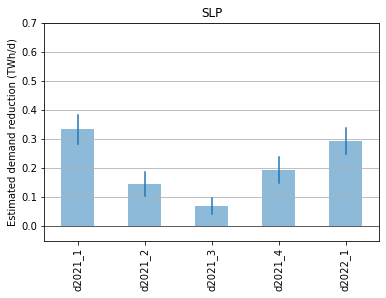

In [378]:
extracted_results = extract_results(results_slp, log=False)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('SLP')
plt.ylim(-0.05, 0.7)

RLM

In [381]:
results_rlm = {}
for m in ['naive', 'temp', 'temp+power', 'temp+power+econ']:
    model = 'rlm ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
    if 'temp' in m:
        model += ' + w2h'
    if 'power' in m:
        model += ' + power + power2 '
    if 'econ' in m:
        model += ' + econ'
    results_rlm[m] = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     344.8
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:04:39   Log-Likelihood:                 1091.6
No. Observations:                1085   AIC:                            -2133.
Df Residuals:                    1060   BIC:                            -2008.
Df Model:                          24                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.2349      0.058     21.152      0.000       1.120       1.349
C(month)[T.2]              -0.0341      0.021     -1.643      0.100      -0.075       0.007
C(month)[T.3]              -0.1142      0.027     -4.206      0.000      -0.167      -0.061
C(month)[T.4]              -0.1406      0.036     -3.958      0.000      -0.210      -0.071
C(month)[T.5]              -0.1462      0.032     -4.632      0.000      -0.208      -0.084
C(month)[T.6]              -0.0426      0.038     -1.113      0.266      -0.118       0.032
C(month)[T.7]               0.0140      0.037      0.375      0.708      -0.059       0.087
C(month)[T.8]              -0.0351      0.037     -0.953      0.340      -0.107       0.037
C(month)[T.9]               0.0115      0.034      0.333      0.739      -0.056       0.079
C(month)[T.10]              0.0002      0.034      0.006      0.995      -0.066       0.066
C(month)[T.11]              0.0527      0.030      1.781      0.075      -0.005       0.111
C(month)[T.12]              0.0287      0.034      0.854      0.393      -0.037       0.095
C(weekday)[T.Monday]        0.0616      0.008      7.458      0.000       0.045       0.078
C(weekday)[T.Saturday]     -0.2420      0.006    -37.809      0.000      -0.255      -0.229
C(weekday)[T.Sunday]       -0.2428      0.008    -31.871      0.000      -0.258      -0.228
C(weekday)[T.Thursday]      0.0686      0.007      9.364      0.000       0.054       0.083
C(weekday)[T.Tuesday]       0.0737      0.009      8.028      0.000       0.056       0.092
C(weekday)[T.Wednesday]     0.0703      0.009      7.740      0.000       0.052       0.088
d2021_1[T.True]             0.1804      0.030      5.932      0.000       0.121       0.240
d2021_2[T.True]             0.0818      0.031      2.649      0.008       0.021       0.142
d2021_3[T.True]            -0.1233      0.024     -5.192      0.000      -0.170      -0.077
d2021_4[T.True]            -0.0396      0.032     -1.247      0.212      -0.102       0.023
d2022_1[T.True]             0.0104      0.039      0.266      0.790      -0.066       0.087
time                     8.676e-06    3.3e-05      0.263      0.793    -5.6e-05    7.34e-05
w2h                         0.4088      0.019     21.319      0.000       0.371       0.446
==============================================================================
Omnibus:                       89.257   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.341
Skew:                          -0.522   Prob(JB):                     4.19e-40
Kurtosis:                       4.709   Cond. No.                     2.68e+04
==============================================================================

Notes:
[1] Standard Errors are h

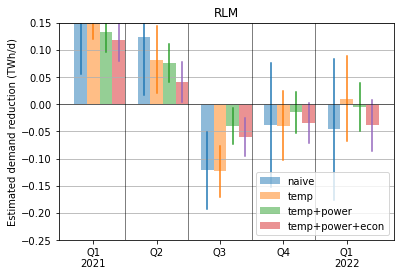

In [382]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

for i, m in enumerate(['naive', 'temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm[m], log=False)
    
    idx = [j-0.2+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('RLM')
plt.ylim(-0.25, 0.15)
plt.xticks(range(len(extracted_results)), 
           [f'Q{date.quarter}'+(f'\n{date.year}' if date.quarter==1 else '')
            for date in pd.date_range('2021-01', '2022-04', freq='3m')])    
plt.legend(loc='lower right')
plt.savefig('rlm.png', dpi=300)

# Disaggregation based on fundamental assumption / energy balances

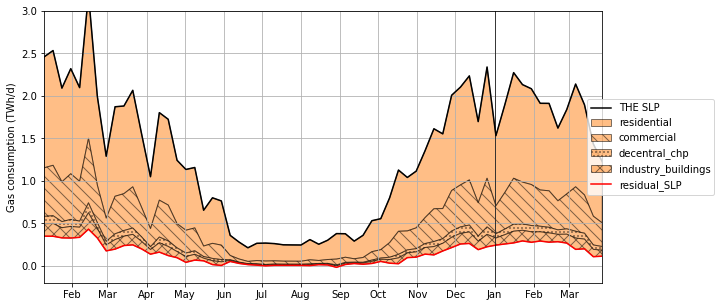

In [35]:
plt.figure(figsize=(10,5))

#weekly
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

upper=dft['slp']
plt.plot(dft.index, dft['slp'], label='THE SLP', color="k")

for sector, h in [
    ("residential", ""), 
    ("commercial",  "\\\\"), 
    ("decentral_chp", "..."),
    ("industry_buildings", "XX")
]:
    plt.fill_between(
        dft.index, upper-dft[sector], upper, label=sector,
        color="tab:orange", hatch=h, edgecolor="k", alpha=0.5)
    upper = upper-dft[sector]

plt.plot(upper.index, upper, color="red", label="residual_SLP")

plt.ylim(-0.2, 3)
plt.axvline(pd.Timestamp('2022-01-01'), color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

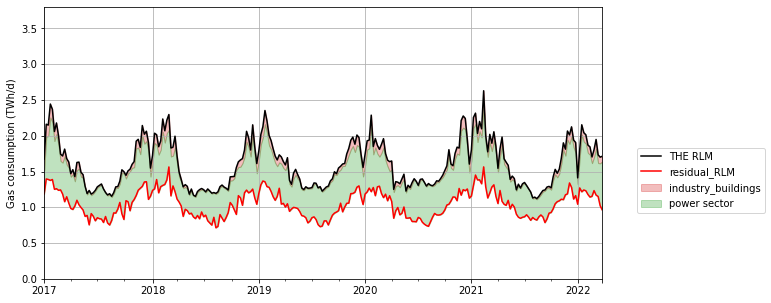

In [18]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["industry_buildings"]

upper=the_rlm
for sector, c, label in [
    (industry,"tab:red","industry_buildings"), 
    (dft['gas_to_electricity'],  "tab:green", "power sector")
    # (dft["scaled_district_heat"], "tab:orange", "dist_heat")
]: 
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 

upper.plot(color="red", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3.8)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

In [19]:
df_x_no_holiday = dfx[(dfx.holiday==0) & (dfx.christmas_period==0) & (dfx.bridgeday==0)]

In [20]:
#SLP
model_the_slp = smf.ols(
    'slp ~ 1 + w2h + C(weekday) + C(month)', 
    data=dfx.loc[(dfx.index <= high_gas_date)&(dfx.index >= '2016-10-01')]
)
results_the_slp = model_the_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_slp.summary()



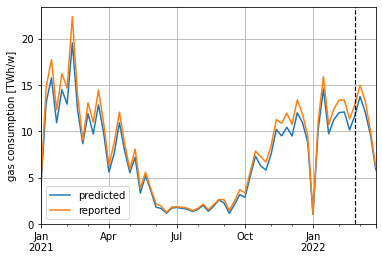

Text(0, 0.5, 'regression delta [TWh/w]')

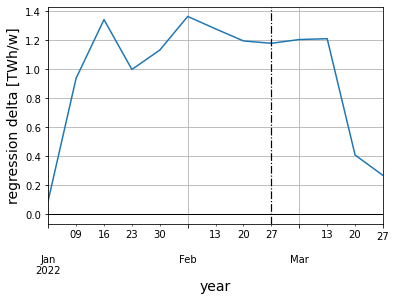

In [21]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").sum().plot(ylim=0).set_ylabel("gas consumption [TWh/w]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 


plt.show()

delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

ax = delta_the_slp.loc[delta_the_slp.index.year==2022].resample("w").sum().plot()
ax.axvline(x=invasion_date, color='k', linestyle='-.', lw=1.2 )
ax.axhline(y=0, color='k', lw=1)
plt.grid()
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)




# Regression variations

## Prices

In [29]:
model_the_prices = smf.ols('rlm ~ 1 + prices + w2h + power + econ + C(weekday)', 
                            data=df_x_no_holiday)
results_the_prices = model_the_prices.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_prices.summary()

## Dummies

In [30]:
dummy = pd.concat([
    pd.Series(1, index=df_x_no_holiday.index[df_x_no_holiday.index>=high_gas_date]),
    pd.Series(0, index=df_x_no_holiday.index[df_x_no_holiday.index<high_gas_date])
])

df_x_no_holiday["D"] = dummy

In [31]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

#2020/09-2021/08 (before high gas prices)

model_rdd_only_slp = smf.ols('rlm ~ 1 +  D + w2h + C(weekday)', data=df_x_no_holiday)
results_rdd_only_slp = model_rdd_only_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6})

model_rdd_no_econ = smf.ols('rlm ~ 1 + D+ w2h + power + C(weekday)', data=df_x_no_holiday)
results_rdd_no_econ = model_rdd_no_econ.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

 
model_rdd_all = smf.ols('rlm ~ 1 + D+ w2h + power + econ + C(weekday)', data=df_x_no_holiday)
results_rdd_all = model_rdd_all.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

Text(0, 0.5, 'estimated reduction [%]')

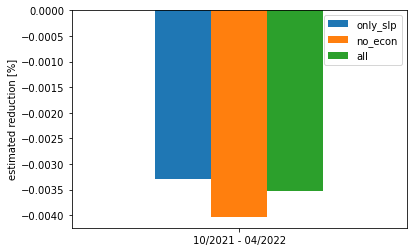

In [32]:
ax = pd.DataFrame(
    data=np.array([
    (results_rdd_all.params.D, results_rdd_no_econ.params.D,  results_rdd_only_slp.params.D), 
    ]), index=["10/2021 - 04/2022"], columns=["only_slp", "no_econ", "all"]
).plot(kind="bar", rot=0)
             
ax.set_ylabel("estimated reduction [%]")

In [33]:
dummy_coefficients = pd.DataFrame(columns=["dummy_coefficients", "P_value"])

for date in pd.date_range("2020-01-01", "2022-03-01", freq="M"):
    
    dummy = pd.concat([
        pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<date.strftime('%Y-%m-%d')]),
        pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=date.strftime('%Y-%m-%d')]),
    ])
    
    df_x_no_holiday["dummy"] = dummy
    
    model = 'rlm ~ 1 + dummy + w2h + time + power + econ + C(weekday)'
    results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})
    
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "dummy_coefficients"] = results.params.dummy
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "P_value"] = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0].loc["dummy"]["P>|z|"]

/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


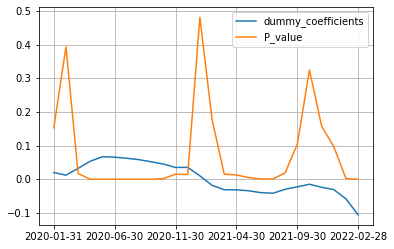

In [34]:
dummy_coefficients.plot()
plt.grid()

### Fitting period variation

In [35]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm ~ 1 + w2h + power + econ + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

model_the_16_10 = smf.ols('rlm ~ 1 + w2h + power + econ + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]

#results_the_20_09.summary()
#results_the_16_10.summary()

### Controlvariable variation

In [36]:
#2020/09-2021/08 (before high gas prices)
result_list_2016 = []
for model_name in ["only_slp", "no_econ", "all"]:
    
    model = smf.ols(
        'rlm ~ 1 + w2h + C(weekday)' 
        + ('+ power' if model_name != 'only_slp' else '')
        + ('+ econ' if model_name == 'all' else '')
        , data=df_x_no_holiday.loc[
        (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')]
    )
    results = model.fit() 

    result_list_2016.append((results, model_name))

In [37]:
def prediction(df, name, start_pred, rlm=True):
    delta = pd.DataFrame()
    key_list = ["reported"]

    if rlm == True:
        rlm_slp = "rlm"
    else: 
        rlm_slp = "slp"
        
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_pred])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_pred][rlm_slp]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index >=start_pred)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    return combined, delta, key_list

In [38]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

expected_amount = df_x_no_holiday.loc[df_x_no_holiday.index>=high_gas_date]["rlm"].sum()

In [39]:
start_pred = high_gas_date

for df, name in result_list_2016:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    result_dict[name] = (
        delta[name][delta[name].index <= high_gas_date].sum() / expected_amount
    )

only_slp    1.797677
reported    1.723729
dtype: float64
no_econ     1.778706
reported    1.723729
dtype: float64
all         1.778591
reported    1.723729
dtype: float64


Text(0, 0.5, 'estimated reduction [%]')

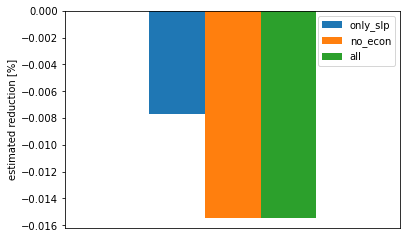

In [40]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45, xticks=[])
ax.set_ylabel("estimated reduction [%]")



fitting period: 2020/09 - 2021/08    1.706871
reported                             1.687251
dtype: float64


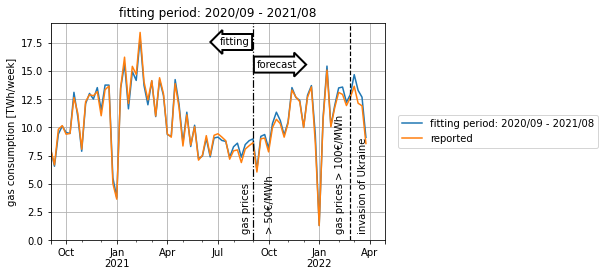

fitting period: 2016/10 - 2021/08    1.613622
reported                             1.613365
dtype: float64


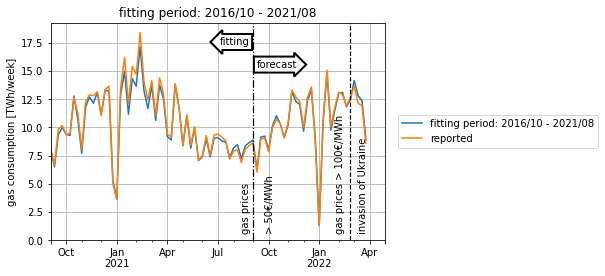

In [46]:
for df, name, start_pred, end_pred in result_list:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    ax = combined.loc["2020-09-01":].resample("1w").sum().plot(ylim=0, xlim=("2020-09-01", "2022-04-30"), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(18, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices" +"\n"+"\n" + "> 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(30, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices > 100€/MWh" + "\n" +"\n" + "invasion of Ukraine", size=10, rotation=90)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 18, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 16, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))
    
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    plt.show()
    
    key_list.append(name)
    

In [42]:
delta.index = combined.index
delta_rlm = delta.dropna()

Q1_delta_rlm = delta_rlm["2022-02-24":].sum(0)

percent = Q1_delta_rlm / combined.loc["2022-02-24":,"reported"].sum(0)*100

weekly_rlm = Q1_delta_rlm / len(delta_rlm["2022-02-24":].index) * 7

print(
    "since war [TWh]:"+ "\n"+ str(Q1_delta_rlm) + "\n" + "\n" +
    "since war [%]:" + "\n"+ str(percent) + "\n" + "\n" +
    "weekly [TWh]:" + "\n"+ str(weekly_rlm)
     )

since war [TWh]:
fitting period: 2016/10 - 2021/08   -1.917391
dtype: float64

since war [%]:
fitting period: 2016/10 - 2021/08   -3.59739
dtype: float64

weekly [TWh]:
fitting period: 2016/10 - 2021/08   -0.447391
dtype: float64


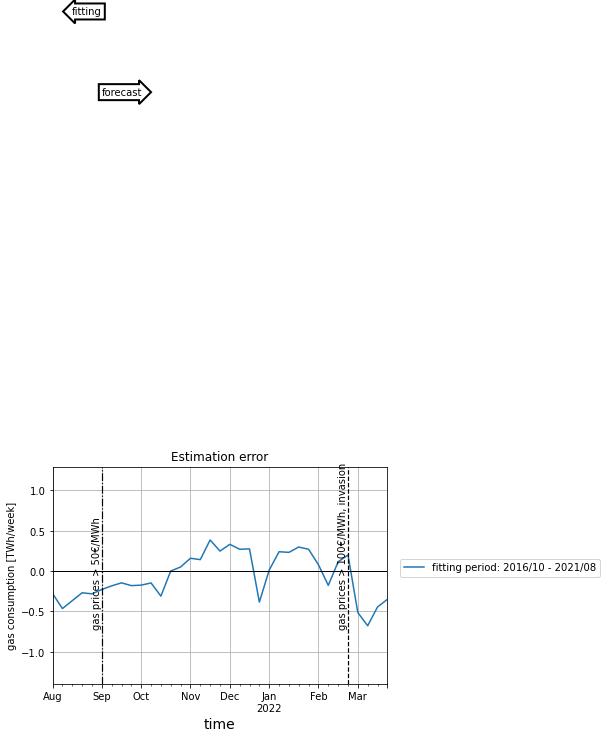

In [43]:
resampled = delta_rlm.resample("1w").sum()

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="Estimation error").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.ylim(resampled.min()[0], resampled.max()[0])


plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 100€/MWh" + ", invasion ", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
plt.xlabel("time",fontsize=14)
plt.axhline(y=0, color='k', lw=1)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 7, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 6, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

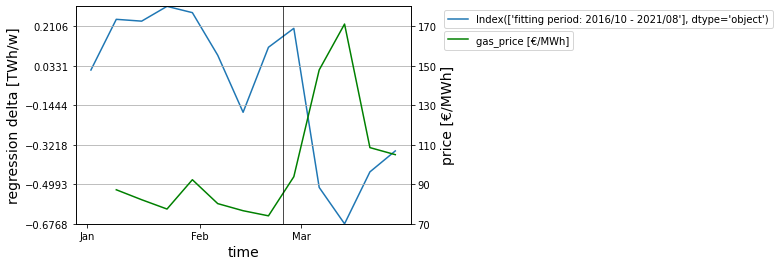

In [44]:
fig,ax = plt.subplots()

column = delta_rlm.columns#[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min()[0], data.max()[0])
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*((data.max() - data.min())[0]) 
ax.set_yticks(np.arange(data.min()[0], data.max()[0], step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["prices"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## Augmented Dickey-Fuller test for stationarity

In [45]:
print(adfuller(df_x_no_holiday['rlm'].dropna(), regression='nc'))

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

print(adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c'))

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however))

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

(-0.9921787411232493, 0.29124600297063213, 18, 1745, {'1%': -2.567022451868211, '5%': -1.9411550247065832, '10%': -1.6166686802127261}, -2203.1988859814583)


KeyError: 'slp_w2h'

## KPSS test for stationarity

In [ ]:
kpss(df_x_no_holiday['rlm'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['power'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['econ'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite